In [23]:
# Necessary imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score,classification_report
import numpy as np
import pandas as pd
import shutil
import itertools
import pathlib
from PIL import Image
import os
import cv2
from google.colab import files, drive
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)


In [3]:
def load_dataset():
    if os.path.exists('/content/brain-tumor-mri-dataset'):
        return

    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes.'.format(name=fn, length=len(uploaded[fn])))

    !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    !kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
    !mkdir brain-tumor-mri-dataset
    !unzip brain-tumor-mri-dataset.zip -d ./brain-tumor-mri-dataset
    clear_output()

load_dataset()

In [4]:
train_dir = '/content/brain-tumor-mri-dataset/Training'
test_dir = '/content/brain-tumor-mri-dataset/Testing'

In [5]:
filepaths =[]
labels = []

folds = os.listdir(train_dir)

for fold in folds:
    f_path = os.path.join(train_dir , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [6]:
train_df

,filepaths,label
0,/content/brain-tumor-mri-dataset/Training/meni...,meningioma
1,/content/brain-tumor-mri-dataset/Training/meni...,meningioma
2,/content/brain-tumor-mri-dataset/Training/meni...,meningioma
3,/content/brain-tumor-mri-dataset/Training/meni...,meningioma
4,/content/brain-tumor-mri-dataset/Training/meni...,meningioma
...,...,...
5707,/content/brain-tumor-mri-dataset/Training/glio...,glioma
5708,/content/brain-tumor-mri-dataset/Training/glio...,glioma
5709,/content/brain-tumor-mri-dataset/Training/glio...,glioma
5710,/content/brain-tumor-mri-dataset/Training/glio...,glioma


In [7]:
filepaths =[]
labels = []

folds = os.listdir(test_dir)

for fold in folds:
    f_path = os.path.join(test_dir , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [8]:
test_df

,filepaths,label
0,/content/brain-tumor-mri-dataset/Testing/menin...,meningioma
1,/content/brain-tumor-mri-dataset/Testing/menin...,meningioma
2,/content/brain-tumor-mri-dataset/Testing/menin...,meningioma
3,/content/brain-tumor-mri-dataset/Testing/menin...,meningioma
4,/content/brain-tumor-mri-dataset/Testing/menin...,meningioma
...,...,...
1306,/content/brain-tumor-mri-dataset/Testing/gliom...,glioma
1307,/content/brain-tumor-mri-dataset/Testing/gliom...,glioma
1308,/content/brain-tumor-mri-dataset/Testing/gliom...,glioma
1309,/content/brain-tumor-mri-dataset/Testing/gliom...,glioma


In [9]:
# train_datagen = ImageDataGenerator(rescale=1./255,
#                                     featurewise_center=False,
#                                     samplewise_center=False,
#                                     featurewise_std_normalization=False,
#                                     samplewise_std_normalization=False,
#                                     zca_whitening=False,
#                                     rotation_range=0,
#                                     zoom_range = 0,
#                                     width_shift_range=0,
#                                     height_shift_range=0,
#                                     horizontal_flip=True,
#                                     vertical_flip=False)

# test_datagen = ImageDataGenerator(rescale=1./255,
#                                    featurewise_center=False,
#                                     samplewise_center=False,
#                                     featurewise_std_normalization=False,
#                                     samplewise_std_normalization=False,
#                                     zca_whitening=False,
#                                     rotation_range=0,
#                                     zoom_range = 0,
#                                     width_shift_range=0,
#                                     height_shift_range=0,
#                                     horizontal_flip=True,
#                                     vertical_flip=False)



# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(256, 256),
#     batch_size=32,
#     class_mode= "categorical",
#     # color_mode='grayscale'
#     )

# test_generator = test_datagen.flow_from_directory(
#     test_dir,
#     target_size=(256, 256),
#     batch_size=32,
#     class_mode= "categorical",
#     # color_mode='grayscale'
#     )

In [10]:
img_size = (256 ,256)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_generator = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

test_generator = ts_gen.flow_from_dataframe(test_df , x_col= 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [11]:
train_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [12]:
test_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [13]:
gen_dict = train_generator.class_indices
classes = list(gen_dict.keys())

In [14]:

# base_model = tf.keras.applications.efficientnet.EfficientNetB3(
#     include_top = False,
#     weights = 'imagenet',
#     input_shape = (256,256,3),
#     pooling=None,
#     # classes=4,
#     classifier_activation="softmax",
# )

# x = base_model.output
# x = Flatten()(x)
# x = BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(rate= 0.4 , seed = 75)(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(rate= 0.2 , seed = 75)(x)
# predictions = Dense(4, activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=predictions)

# for layer in base_model.layers:
#     layer.trainable = False


# model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [15]:
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet' ,
                                                               input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(512, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.2 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

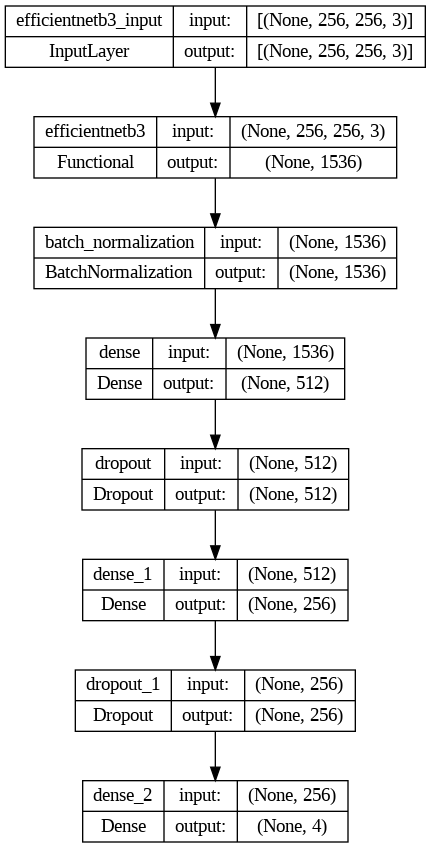

In [28]:
keras.utils.plot_model(model, show_shapes=True)

In [17]:
model_es = EarlyStopping(
    monitor = 'loss',
    min_delta = 1e-11,
    patience = 12,
    verbose = 1
    )

model_rlr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 6,
    verbose = 1
    )

model_mcp = ModelCheckpoint(
    filepath = 'EfficientNetB3_model_weights.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only = True,
    verbose = 1
    )

history = model.fit(
    train_generator,
    steps_per_epoch=5712//32,
    epochs=20,
    validation_data=test_generator,
    validation_steps= 1311//32,
    callbacks=[model_es, model_rlr, model_mcp]
    )


Epoch 1/20
178/178 [==============================] - ETA: 0s - loss: 15.1582 - accuracy: 0.8258
Epoch 1: val_accuracy improved from -inf to 0.76250, saving model to EfficientNetB3_model_weights.h5
178/178 [==============================] - 137s 387ms/step - loss: 15.1582 - accuracy: 0.8258 - val_loss: 11.5329 - val_accuracy: 0.7625 - lr: 0.0010
Epoch 2/20
178/178 [==============================] - ETA: 0s - loss: 8.9169 - accuracy: 0.9098
Epoch 2: val_accuracy improved from 0.76250 to 0.88750, saving model to EfficientNetB3_model_weights.h5
178/178 [==============================] - 67s 373ms/step - loss: 8.9169 - accuracy: 0.9098 - val_loss: 7.0714 - val_accuracy: 0.8875 - lr: 0.0010
Epoch 3/20
178/178 [==============================] - ETA: 0s - loss: 5.4996 - accuracy: 0.9470
Epoch 3: val_accuracy improved from 0.88750 to 0.96719, saving model to EfficientNetB3_model_weights.h5
178/178 [==============================] - 67s 374ms/step - loss: 5.4996 - accuracy: 0.9470 - val_loss: 4

In [18]:
# Evaluating the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples//32)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

40/40 [==============================] - 4s 90ms/step - loss: 0.1979 - accuracy: 0.9984
Test Loss: 0.19793
Test Accuracy: 0.99844


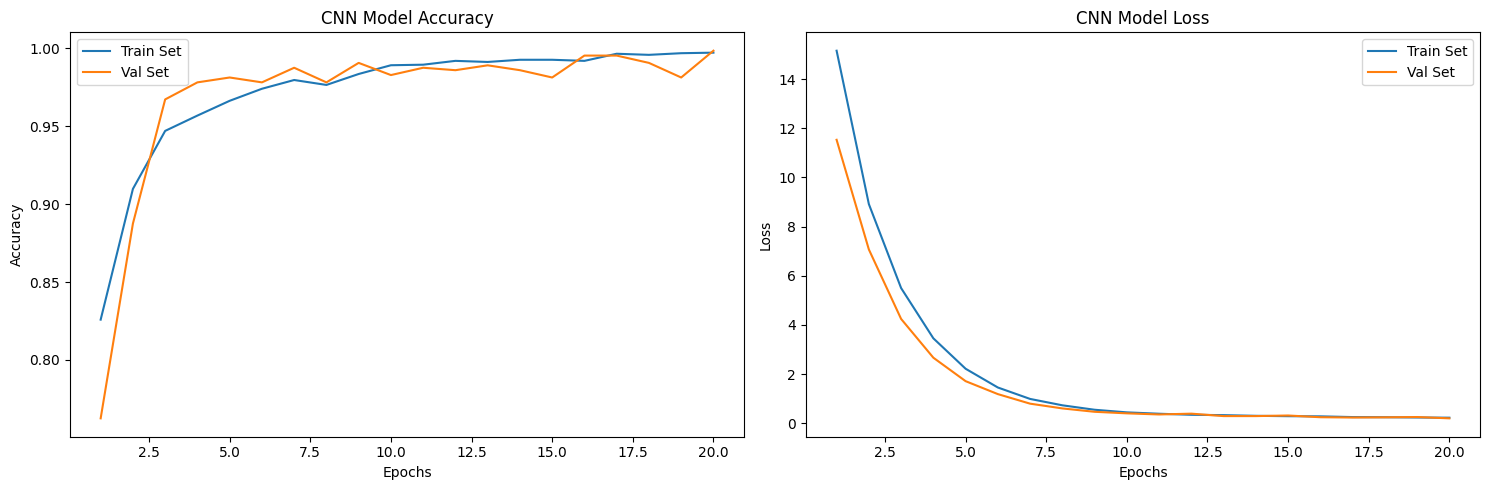

In [19]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model Loss')

plt.tight_layout()
plt.show()

In [20]:
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']


In [24]:
preds = model.predict_generator(test_generator)

y_pred = np.argmax(preds , axis = 1)

<ipython-input-24-8f4012fcbd7d>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator)


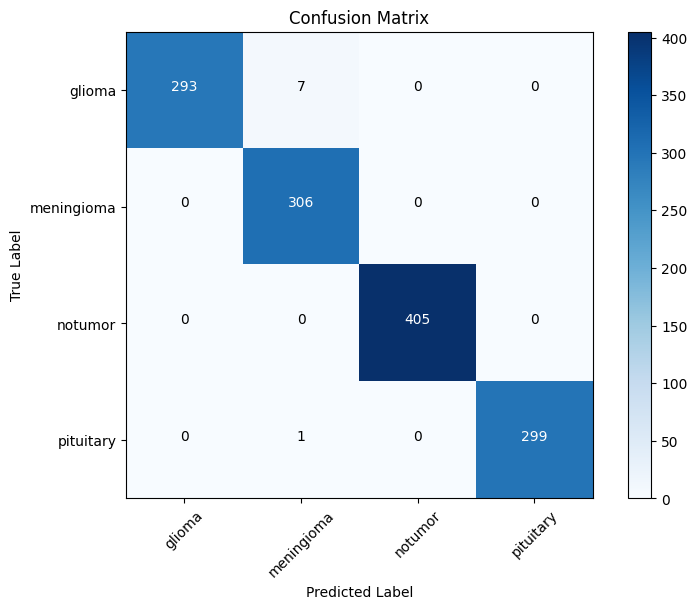

In [27]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize= (8, 6))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [26]:
#Classification Report
print(classification_report(test_generator.classes, y_pred , target_names= categories))

              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       300
  meningioma       0.97      1.00      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311

